In [7]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

try:
    train_df=pd.read_csv('train_data.csv')
    valid_df=pd.read_csv('valid_data.csv')

    print("Dataset loaded successfully")
except FileNotFoundError:
    print("File not found.")

print("\nTraining Data info")
train_df.info()

print(train_df.isnull().sum())

Dataset loaded successfully

Training Data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16990 entries, 0 to 16989
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16990 non-null  object
 1   label   16990 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 265.6+ KB
text     0
label    0
dtype: int64


C:\Users\Sameer Tripathi\AppData\Local\Temp\ipykernel_11936\3420384139.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=train_df, palette='viridis',order=train_df['label'].value_counts().index)


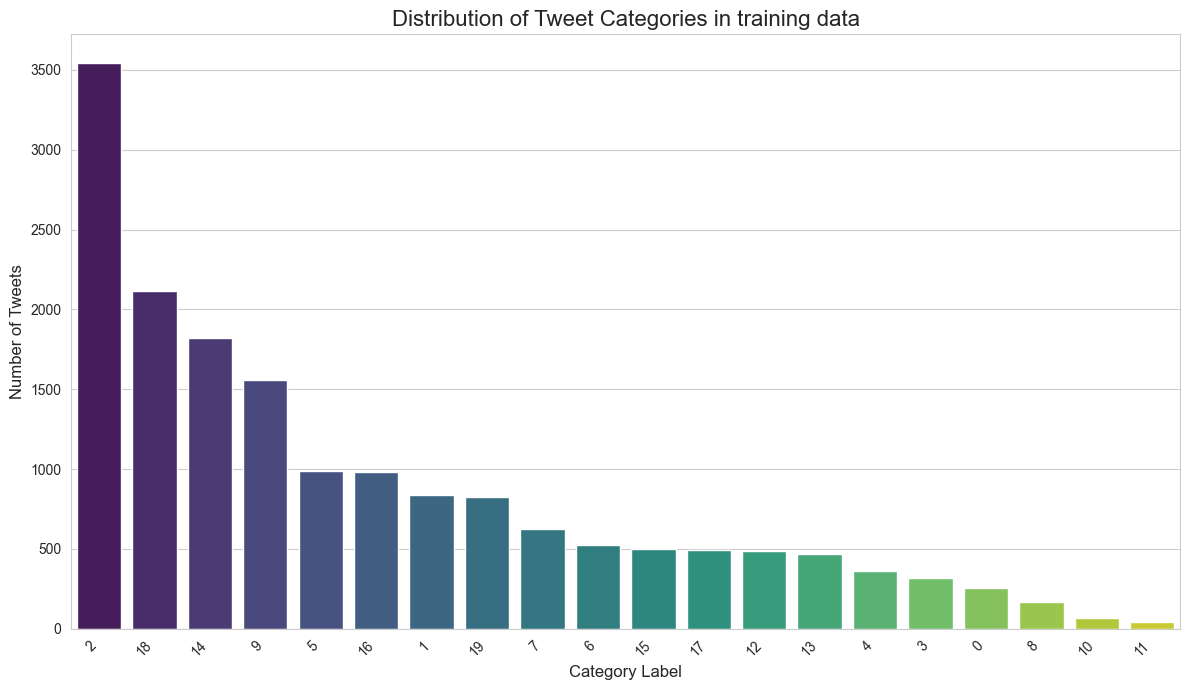

In [8]:
plt.figure(figsize=(12,7))

sns.countplot(x='label', data=train_df, palette='viridis',order=train_df['label'].value_counts().index)

plt.title('Distribution of Tweet Categories in training data', fontsize=16)
plt.xlabel('Category Label', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [9]:
import nltk

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt_tab to C:\Users\Sameer
[nltk_data]     Tripathi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sameer
[nltk_data]     Tripathi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sameer
[nltk_data]     Tripathi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

lemmatizer=WordNetLemmatizer()
stop_words=set(stopwords.words('english'))

def clean_text(text):
    text=re.sub(r'@\w+|#|w+', '',text)

    text=text.lower()

    text=text.translate(str.maketrans('','',string.punctuation))

    tokens=word_tokenize(text)

    cleaned_tokens=[
        lemmatizer.lemmatize(word) for word in tokens
        if word.isalpha() and word not in stop_words
    ]

    return " ".join(cleaned_tokens)

In [11]:
print("Cleaning trained data...")
train_df['cleaned_text']=train_df['text'].apply(clean_text)

print("Cleaning validation data")
valid_df['cleaned_text']=valid_df['text'].apply(clean_text)

pd.set_option('display.max_colwidth',None)
print(train_df[['text', 'cleaned_text']].head())

Cleaning trained data...
Cleaning validation data
                                                                                                                             text  \
0  Here are Thursday's biggest analyst calls: Apple, Amazon, Tesla, Palantir, DocuSign, Exxon &amp; more  https://t.co/QPN8Gwl7Uh   
1                                    Buy Las Vegas Sands as travel to Singapore builds, Wells Fargo says  https://t.co/fLS2w57iCz   
2                   Piper Sandler downgrades DocuSign to sell, citing elevated risks amid CEO transition  https://t.co/1EmtywmYpr   
3               Analysts react to Tesla's latest earnings, break down what's next for electric car maker  https://t.co/kwhoE6W06u   
4     Netflix and its peers are set for a ‘return to growth,’ analysts say, giving one stock 120% upside  https://t.co/jPpdl0D9s4   

                                                                     cleaned_text  
0    thursday biggest analyst call apple amazon tesla palantir docu

In [12]:
#Feature Engineering & Baseline Model
#Feature Engineering with TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer
#limit it to the top 5000 most frequent words to keep our model efficient
tfid_vectorizer=TfidfVectorizer(max_features=5000)

X_train=tfid_vectorizer.fit_transform(train_df['cleaned_text'])
y_train=train_df['label']

X_valid=tfid_vectorizer.transform(valid_df['cleaned_text'])
y_valid=valid_df['label']

print("TF-IDF vectors created successfully")
print("Shape of training features: ", X_train.shape)
print("Shape of validation features: ", X_valid.shape)


TF-IDF vectors created successfully
Shape of training features:  (16990, 5000)
Shape of validation features:  (4117, 5000)


In [13]:
#Train a Baseline Model (Logistic Regression)
from sklearn.linear_model import LogisticRegression

lr_model=LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)
lr_model.fit(X_train,y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [14]:
from sklearn.metrics import classification_report

y_preds=lr_model.predict(X_valid)
print("\n--- Classification Report for Logistic Regression ---")
print(classification_report(y_valid,y_preds))


--- Classification Report for Logistic Regression ---
              precision    recall  f1-score   support

           0       0.68      0.86      0.76        73
           1       0.80      0.80      0.80       214
           2       0.86      0.75      0.80       852
           3       0.77      0.81      0.78        77
           4       0.95      0.99      0.97        97
           5       0.94      0.92      0.93       242
           6       0.67      0.87      0.76       146
           7       0.85      0.87      0.86       160
           8       0.61      0.78      0.68        32
           9       0.64      0.68      0.66       336
          10       0.35      0.69      0.46        13
          11       0.78      1.00      0.88        14
          12       0.78      0.89      0.83       119
          13       0.71      0.78      0.74       116
          14       0.81      0.71      0.76       415
          15       0.69      0.79      0.74       125
          16       0.87   

In [15]:
#Train the LightGBM Model
import lightgbm as lgb
from sklearn.metrics import classification_report
lgb_model=lgb.LGBMClassifier(
    class_weight='balanced',
    random_state=42
)

lgb_model.fit(X_train, y_train)

y_preds_lgbm=lgb_model.predict(X_valid)
print(classification_report(y_valid,y_preds_lgbm))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43790
[LightGBM] [Info] Number of data points in the train set: 16990, number of used features: 1678
[LightGBM] [Info] Start training from score -2.995732
[LightGBM] [Info] Start training from score -2.995732
[LightGBM] [Info] Start training from score -2.995732
[LightGBM] [Info] Start training from score -2.995732
[LightGBM] [Info] Start training from score -2.995732
[LightGBM] [Info] Start training from score -2.995732
[LightGBM] [Info] Start training from score -2.995732
[LightGBM] [Info] Start training from score -2.995732
[LightGBM] [Info] Start training from score -2.995732
[LightGBM] [Info] Start training from score -2.995732
[LightGBM] [Info] Start training from score -2.995732
[LightGBM] [Info] Start training from score -2.995732
[LightGBM] [Info] Start training from score -2.995732
[Light

c:\Users\Sameer Tripathi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.72      0.71      0.72        73
           1       0.87      0.85      0.86       214
           2       0.81      0.77      0.79       852
           3       0.86      0.74      0.80        77
           4       0.97      0.95      0.96        97
           5       0.94      0.92      0.93       242
           6       0.77      0.82      0.79       146
           7       0.86      0.88      0.87       160
           8       0.70      0.81      0.75        32
           9       0.62      0.74      0.68       336
          10       0.53      0.62      0.57        13
          11       0.81      0.93      0.87        14
          12       0.83      0.82      0.82       119
          13       0.72      0.70      0.71       116
          14       0.78      0.78      0.78       415
          15       0.71      0.73      0.72       125
          16       0.90      0.87      0.89       249
          17       0.78    

In [16]:
#Deep Learning with LSTM
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
VOCAB_SIZE=5000
tokenizer=Tokenizer(num_words=VOCAB_SIZE,oov_token='<OOV>')# <OOV> is for out-of-vocabulary words
tokenizer.fit_on_texts(train_df['cleaned_text'])

X_train_seq=tokenizer.texts_to_sequences(train_df['cleaned_text'])

X_valid_seq=tokenizer.texts_to_sequences(valid_df['cleaned_text'])

MAX_LENGTH=50
X_train_padded=pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_valid_padded=pad_sequences(X_valid_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')

y_train_np=train_df['label'].to_numpy()
y_valid_np=valid_df['label'].to_numpy()
print("Shape of padded training data: ", X_train_padded.shape)


Shape of padded training data:  (16990, 50)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

lstm_model=Sequential({
     # 1. Embedding Layer: Turns the integer sequences into dense vectors of a fixed size.
    # It learns word similarities from the data.
    Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=MAX_LENGTH),


    # 2. LSTM Layer: The core of the model. Processes the sequence of word vectors.
    LSTM(64, return_sequences=False), # return_sequences=False because it's the last recurrent layer

      # 3. Dropout Layer: A regularization technique to prevent overfitting.
     Dropout(0.5),

     Dense(20,activation='softmax')

})
lstm_model.summary()

c:\Users\Sameer Tripathi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
from sklearn.utils import class_weight
import numpy as np

class_weights=class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict=dict(enumerate(class_weights))
print("Class weight dictionary:\n", class_weight_dict)

Class weight dictionary:
 {0: 3.331372549019608, 1: 1.0149342891278375, 2: 0.23963328631875883, 3: 2.646417445482866, 4: 2.3662952646239552, 5: 0.8606889564336373, 6: 1.6211832061068703, 7: 1.361378205128205, 8: 5.117469879518072, 9: 0.5456005138086063, 10: 12.31159420289855, 11: 19.306818181818183, 12: 1.74435318275154, 13: 1.8036093418259023, 14: 0.4662458836443469, 15: 1.6956087824351298, 16: 0.8624365482233503, 17: 1.7161616161616162, 18: 0.40108593012275734, 19: 1.0321992709599028}


In [19]:
lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history=lstm_model.fit(
    X_train_padded,
    y_train_np,
    epochs=5,
    validation_data=(X_valid_padded, y_valid_np),
    verbose=1
)

Epoch 1/5


ValueError: Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 50)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Bidirectional,LSTM,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

lstm_model_v2=Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=MAX_LENGTH),

    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),

    Dropout(0.5),

    Dense(64,activation='relu'),

    Dense(20, activation='softmax')
])

lstm_model_v2.summary()

c:\Users\Sameer Tripathi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
lstm_model_v2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history=lstm_model_v2.fit(
    X_train_padded,
    y_train_np,
    epochs=20,
    validation_data=(X_valid_padded, y_valid_np),
    callbacks=[early_stopping],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.2393 - loss: 2.3263 - val_accuracy: 0.5650 - val_loss: 1.5374
Epoch 2/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 37s 70ms/step - accuracy: 0.5474 - loss: 1.1928 - val_accuracy: 0.6672 - val_loss: 1.1236
Epoch 3/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 36s 67ms/step - accuracy: 0.6839 - loss: 0.7645 - val_accuracy: 0.6612 - val_loss: 1.1404
Epoch 4/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 37s 70ms/step - accuracy: 0.7664 - loss: 0.5418 - val_accuracy: 0.7073 - val_loss: 1.0261
Epoch 5/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 45s 77ms/step - accuracy: 0.8152 - loss: 0.4309 - val_accuracy: 0.7299 - val_loss: 1.0701
Epoch 6/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 42s 79ms/step - accuracy: 0.8545 - loss: 0.3408 - val_accuracy: 0.7241 - val_loss: 1.1093
Epoch 7/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - accuracy: 0.8788 - loss: 0.2762 - val_accuracy: 0.7605 - val_loss: 1.0919


In [22]:
from sklearn.metrics import classification_report

y_probs_lstm=lstm_model_v2.predict(X_valid_padded)

y_preds_lstm=np.argmax(y_probs_lstm, axis=1)
print(classification_report(y_valid_np,y_preds_lstm))

129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
              precision    recall  f1-score   support

           0       0.51      0.62      0.56        73
           1       0.77      0.71      0.74       214
           2       0.84      0.51      0.64       852
           3       0.42      0.83      0.56        77
           4       0.92      0.94      0.93        97
           5       0.91      0.92      0.91       242
           6       0.76      0.84      0.80       146
           7       0.70      0.87      0.77       160
           8       0.71      0.94      0.81        32
           9       0.56      0.60      0.58       336
          10       0.35      0.85      0.50        13
          11       0.13      0.86      0.23        14
          12       0.89      0.78      0.83       119
          13       0.43      0.66      0.52       116
          14       0.77      0.65      0.71       415
          15       0.61      0.84      0.71       125
          16       0.82      0.88      

In [23]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf

MODEL_NAME='distilbert-base-uncased'

tokenizer=DistilBertTokenizer.from_pretrained(MODEL_NAME)

model=TFDistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=20
)


c:\Users\Sameer Tripathi\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForS

In [24]:
train_texts=train_df['text'].tolist()
valid_texts=valid_df['text'].tolist()

train_encodings=tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=64
)

valid_encodings=tokenizer(
    valid_texts,
    truncation=True,
    padding=True,
    max_length=64
)

train_dataset=tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

valid_dataset=tf.data.Dataset.from_tensor_slices((
    dict(valid_encodings),
    y_valid
))


In [ ]:
import tensorflow as tf
from tf_keras.callbacks import EarlyStopping
from tf_keras.optimizers import Adam


loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss=loss,
    metrics=['accuracy']
)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)


print("\nFine-tuning the DistilBERT model...")
history = model.fit(
    train_dataset.shuffle(1000).batch(16),
    epochs=5,
    batch_size=16,
    validation_data=valid_dataset.batch(64),
    callbacks=[early_stopping] 
)
print("✅ Model fine-tuning complete.")


Fine-tuning the DistilBERT model...
Epoch 1/5
1062/1062 [==============================] - 5019s 5s/step - loss: 0.2461 - accuracy: 0.9402 - val_loss: 3.3885 - val_accuracy: 0.3602
Epoch 2/5
1062/1062 [==============================] - 4927s 5s/step - loss: 0.1583 - accuracy: 0.9600 - val_loss: 3.3459 - val_accuracy: 0.3811
Epoch 3/5
1062/1062 [==============================] - 5527s 5s/step - loss: 0.1191 - accuracy: 0.9693 - val_loss: 3.4477 - val_accuracy: 0.4107
Epoch 4/5
1062/1062 [==============================] - 5485s 5s/step - loss: 0.1058 - accuracy: 0.9730 - val_loss: 3.1251 - val_accuracy: 0.4122
Epoch 5/5
1062/1062 [==============================] - 4971s 5s/step - loss: 0.0977 - accuracy: 0.9760 - val_loss: 3.2132 - val_accuracy: 0.4088
✅ Model fine-tuning complete.


In [40]:
from sklearn.metrics import classification_report
import numpy as np

preds=model.predict(valid_dataset.batch(64)).logits

y_preds_bert=np.argmax(preds,axis=1)

print("\nClassification report for DistilBERT\n")
print(classification_report(y_valid,y_preds_bert))


65/65 [==============================] - 247s 4s/step

Classification report for DistilBERT

              precision    recall  f1-score   support

           0       0.01      0.01      0.01        73
           1       0.00      0.00      0.00       214
           2       1.00      0.16      0.28       852
           3       0.14      0.97      0.25        77
           4       0.25      0.01      0.02        97
           5       0.96      0.21      0.34       242
           6       0.00      0.00      0.00       146
           7       0.00      0.00      0.00       160
           8       0.00      0.00      0.00        32
           9       0.82      0.12      0.21       336
          10       0.00      0.00      0.00        13
          11       0.71      0.36      0.48        14
          12       0.00      0.00      0.00       119
          13       0.00      0.00      0.00       116
          14       0.67      0.86      0.75       415
          15       0.02      0.01      0.0

c:\Users\Sameer Tripathi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sameer Tripathi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sameer Tripathi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh